# Brains4Buildings interactive inverse grey-box analysis pipeline

This Jupyter Labs notebook can be used to interactively test the Brains4Buildings inverse grey-box analysis pipeline.
Don't forget to install the requirements listed in [requirements.txt](../requirements.txt) first!



## Setting the stage

First several imports and variables need to be defined


### Imports and generic settings

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
# import matplotlib.pyplot as plt

# usually, two decimals suffice for displaying DataFrames (NB internally, precision may be higher)
pd.options.display.precision = 2

from tqdm.notebook import tqdm
from gekko import GEKKO

import sys
sys.path.append('../data/')
sys.path.append('../view/')
sys.path.append('../analysis/')

from preprocessor import Preprocessor
from inversegreyboxmodel import Learner
from plotter import Plot


%load_ext autoreload
%matplotlib inline
%matplotlib widget

import logging
logging.basicConfig(level=logging.ERROR, 
                    format='%(asctime)s %(levelname)-8s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    filename='log_b4b.txt',
                   )

### Load Measured Data from parquet file

In [2]:
%%time
# Prerequisite: for this example to work, you need to have the b4b_raw_properties.parquet, located in the ../data/ folder.
# One way to get this is to run B4BExtractionBackup.ipynb first, but then you have to run this code on the energietransitiewindesheim.nl server

df_prop = pd.read_parquet('../data/b4b_raw_properties.parquet', engine='pyarrow')

#sorting the DataFrame index is needed to get good performance on certain filters
#this guarding code to check whether DataFramews are properly sorted
if not df_prop.index.is_monotonic_increasing:
    print('df needed index sorting')
    df_prop = df_prop.sort_index()  

CPU times: total: 109 ms
Wall time: 113 ms


In [3]:
df_prop.index.unique(level='id').values

array([900846, 917810, 924038, 925038, 948634, 999169], dtype=int64)

In [4]:
df_prop.index.unique(level='source').values

array(['CO2-meter-SCD4x', 'bms', 'xovis', 'human_observer'], dtype=object)

In [5]:
df_prop

property                                          co2__ppm  door_open__bool  \
id     source          timestamp                                              
900846 CO2-meter-SCD4x 2022-10-06 13:49:00+02:00     527.0             <NA>   
                       2022-10-06 13:50:00+02:00     530.0             <NA>   
                       2022-10-06 14:00:00+02:00     504.0             <NA>   
                       2022-10-06 14:10:00+02:00     500.0             <NA>   
                       2022-10-06 14:20:00+02:00     418.0             <NA>   
...                                                    ...              ...   
999169 xovis           2022-11-02 13:35:00+01:00       NaN             <NA>   
                       2022-11-02 13:40:00+01:00       NaN             <NA>   
                       2022-11-02 13:45:00+01:00       NaN             <NA>   
                       2022-11-02 13:50:00+01:00       NaN             <NA>   
                       2022-11-02 13:55:00+01:00       NaN             <NA>   

property                                          occupancy__bool  \
id     source          timestamp                                    
900846 CO2-meter-SCD4x 2022-10-06 13:49:00+02:00             <NA>   
                       2022-10-06 13:50:00+02:00             <NA>   
                       2022-10-06 14:00:00+02:00             <NA>   
                       2022-10-06 14:10:00+02:00             <NA>   
                       2022-10-06 14:20:00+02:00             <NA>   
...                                                           ...   
999169 xovis           2022-11-02 13:35:00+01:00             <NA>   
                       2022-11-02 13:40:00+01:00             <NA>   
                       2022-11-02 13:45:00+01:00             <NA>   
                       2022-11-02 13:50:00+01:00             <NA>   
                       2022-11-02 13:55:00+01:00             <NA>   

property                                          occupancy__p  \
id     source          timestamp                                 
900846 CO2-meter-SCD4x 2022-10-06 13:49:00+02:00             2   
                       2022-10-06 13:50:00+02:00             2   
                       2022-10-06 14:00:00+02:00             2   
                       2022-10-06 14:10:00+02:00             2   
                       2022-10-06 14:20:00+02:00             2   
...                                                        ...   
999169 xovis           2022-11-02 13:35:00+01:00             0   
                       2022-11-02 13:40:00+01:00             0   
                       2022-11-02 13:45:00+01:00             0   
                       2022-11-02 13:50:00+01:00             0   
                       2022-11-02 13:55:00+01:00             0   

property                                          rel_humidity__0  \
id     source          timestamp                                    
900846 CO2-meter-SCD4x 2022-10-06 13:49:00+02:00             0.58   
                       2022-10-06 13:50:00+02:00             0.51   
                       2022-10-06 14:00:00+02:00             0.44   
                       2022-10-06 14:10:00+02:00             0.43   
                       2022-10-06 14:20:00+02:00             0.43   
...                                                           ...   
999169 xovis           2022-11-02 13:35:00+01:00              NaN   
                       2022-11-02 13:40:00+01:00              NaN   
                       2022-11-02 13:45:00+01:00              NaN   
                       2022-11-02 13:50:00+01:00              NaN   
                       2022-11-02 13:55:00+01:00              NaN   

property                                          temp_in__degC  \
id     source          timestamp                                  
900846 CO2-meter-SCD4x 2022-10-06 13:49:00+02:00           22.5   
                       2022-10-06 13:50:00+02:00           23.1   
                       2022-10-06 14:00:00+02:00 

In [6]:
df_prop.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 130030 entries, (900846, 'CO2-meter-SCD4x', Timestamp('2022-10-06 13:49:00+0200', tz='Europe/Amsterdam')) to (999169, 'xovis', Timestamp('2022-11-02 13:55:00+0100', tz='Europe/Amsterdam'))
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   co2__ppm           120351 non-null  float32
 1   door_open__bool    29 non-null      Int8   
 2   occupancy__bool    103338 non-null  Int8   
 3   occupancy__p       24334 non-null   Int8   
 4   rel_humidity__0    118338 non-null  float32
 5   temp_in__degC      120351 non-null  float32
 6   valve_frac__0      104009 non-null  float32
 7   window_open__bool  29 non-null      Int8   
dtypes: Int8(4), float32(4)
memory usage: 5.0+ MB


## Preprocessing

In [7]:
df_prep = Preprocessor.preprocess_room_data(df_prop)

  0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14991 entries, (900846, Timestamp('2022-10-06 00:00:00+0200', tz='Europe/Amsterdam')) to (999169, Timestamp('2022-11-02 23:45:00+0100', tz='Europe/Amsterdam'))
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CO2-meter-SCD4x_co2__ppm           10107 non-null  float32
 1   bms_co2__ppm                       12661 non-null  float32
 2   human_observer_co2__ppm            0 non-null      float32
 3   xovis_co2__ppm                     0 non-null      float32
 4   CO2-meter-SCD4x_door_open__bool    0 non-null      Int8   
 5   bms_door_open__bool                0 non-null      Int8   
 6   human_observer_door_open__bool     160 non-null    Int8   
 7   xovis_door_open__bool              0 non-null      Int8   
 8   CO2-meter-SCD4x_occupancy__bool    0 non-null      Int8   
 9   bms_occupancy__bool                4612 non-null

In [9]:
df_prep.describe()

,CO2-meter-SCD4x_co2__ppm,bms_co2__ppm,human_observer_co2__ppm,xovis_co2__ppm,CO2-meter-SCD4x_door_open__bool,bms_door_open__bool,human_observer_door_open__bool,xovis_door_open__bool,CO2-meter-SCD4x_occupancy__bool,bms_occupancy__bool,...,human_observer_temp_in__degC,xovis_temp_in__degC,CO2-meter-SCD4x_valve_frac__0,bms_valve_frac__0,human_observer_valve_frac__0,xovis_valve_frac__0,CO2-meter-SCD4x_window_open__bool,bms_window_open__bool,human_observer_window_open__bool,xovis_window_open__bool
count,10107.00,12661.00,0.0,0.0,0.0,0.0,160.0,0.0,0.0,4612.0,...,0.0,0.0,0.0,7295.00,0.0,0.0,0.0,0.0,160.0,0.0
mean,418.18,439.49,NaN,NaN,<NA>,<NA>,0.12,<NA>,<NA>,0.11,...,NaN,NaN,NaN,0.56,NaN,NaN,<NA>,<NA>,0.09,<NA>
std,92.48,76.10,NaN,NaN,<NA>,<NA>,0.33,<NA>,<NA>,0.31,...,NaN,NaN,NaN,0.38,NaN,NaN,<NA>,<NA>,0.28,<NA>
min,244.00,314.70,NaN,NaN,<NA>,<NA>,0.0,<NA>,<NA>,0.0,...,NaN,NaN,NaN,0.20,NaN,NaN,<NA>,<NA>,0.0,<NA>
25%,357.00,386.35,NaN,NaN,<NA>,<NA>,0.0,<NA>,<NA>,0.0,...,NaN,NaN,NaN,0.20,NaN,NaN,<NA>,<NA>,0.0,<NA>
50%,417.50,436.33,NaN,NaN,<NA>,<NA>,0.0,<NA>,<NA>,0.0,...,NaN,NaN,NaN,0.20,NaN,NaN,<NA>,<NA>,0.0,<NA>
75%,456.79,469.67,NaN,NaN,<NA>,<NA>,0.0,<NA>,<NA>,0.0,...,NaN,NaN,NaN,1.00,NaN,NaN,<NA>,<NA>,0.0,<NA>
max,1236.75,1150.33,NaN,NaN,<NA>,<NA>,1.0,<NA>,<NA>,1.0,...,NaN,NaN,NaN,1.00,NaN,NaN,<NA>,<NA>,1.0,<NA>


In [10]:
%autoreload 2
units_to_mathtext = property_types = {
    'degC' : r'$°C$',
    'ppm' : r'$ppm$',
    '0' : r'$[-]$',
    'bool': r'$0 = False; 1 = True$',
    'p' : r'$persons$'
}

In [11]:
# visualize input data
df_plot = df_prep

In [12]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 14991 entries, (900846, Timestamp('2022-10-06 00:00:00+0200', tz='Europe/Amsterdam')) to (999169, Timestamp('2022-11-02 23:45:00+0100', tz='Europe/Amsterdam'))
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   CO2-meter-SCD4x_co2__ppm           10107 non-null  float32
 1   bms_co2__ppm                       12661 non-null  float32
 2   human_observer_co2__ppm            0 non-null      float32
 3   xovis_co2__ppm                     0 non-null      float32
 4   CO2-meter-SCD4x_door_open__bool    0 non-null      Int8   
 5   bms_door_open__bool                0 non-null      Int8   
 6   human_observer_door_open__bool     160 non-null    Int8   
 7   xovis_door_open__bool              0 non-null      Int8   
 8   CO2-meter-SCD4x_occupancy__bool    0 non-null      Int8   
 9   bms_occupancy__bool                4612 non-null

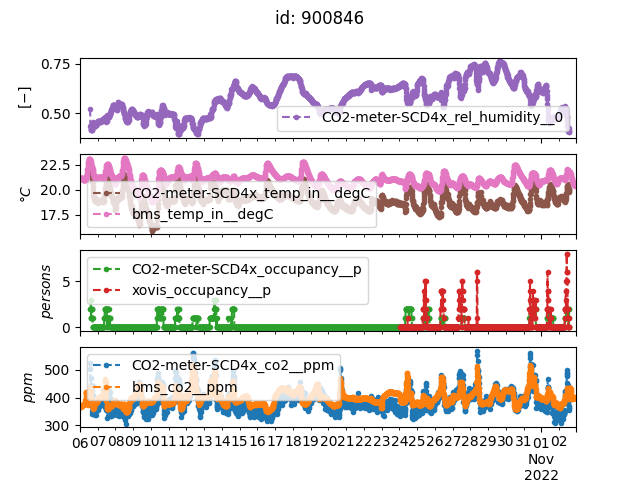

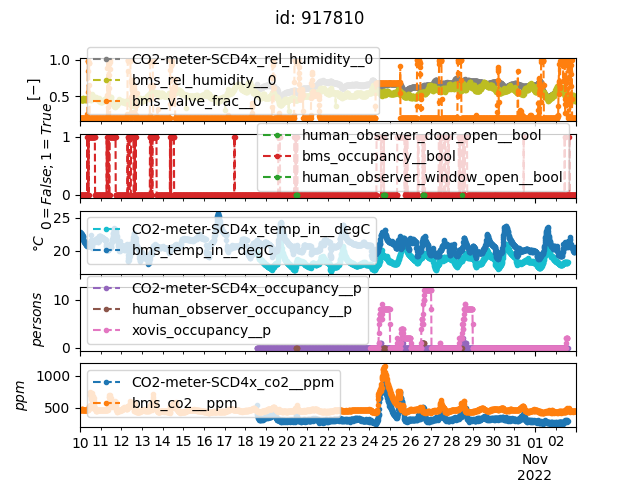

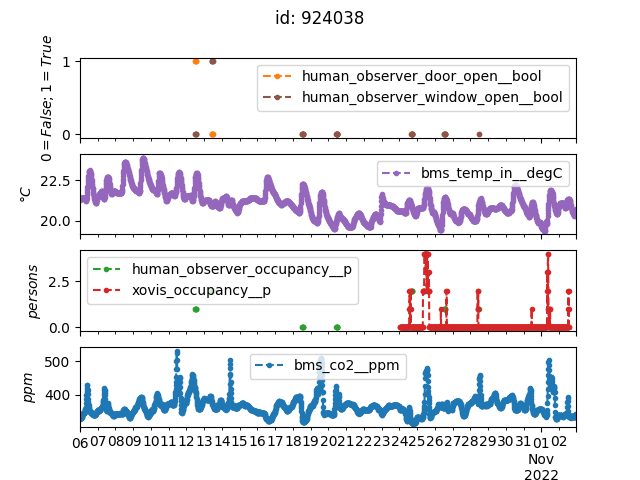

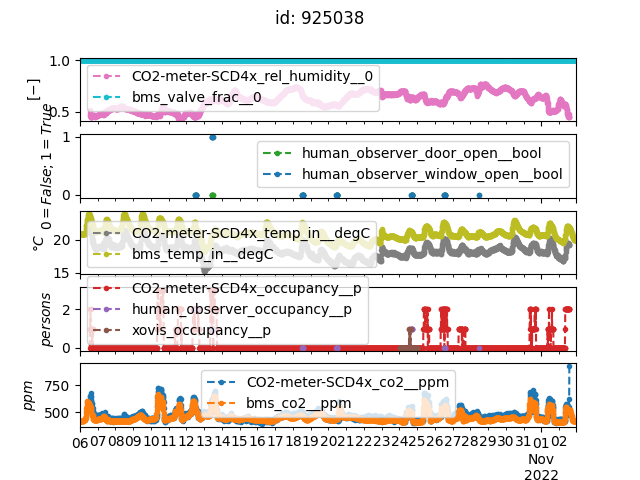

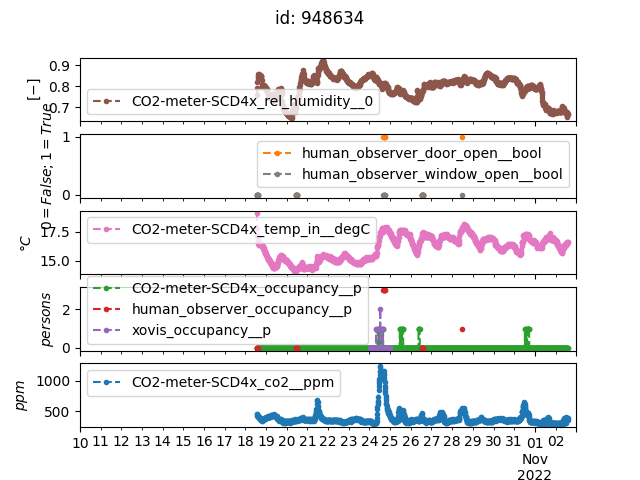

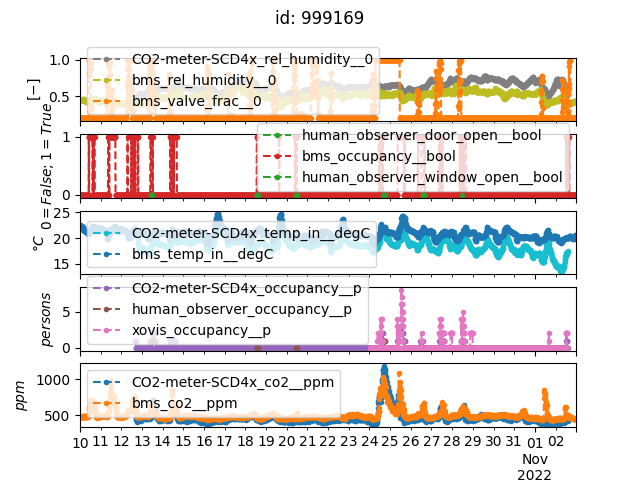

In [13]:
#Plot all properties from all sources for all ids
Plot.dataframe_preprocessed_plot(df_plot, units_to_mathtext)

## Learn parameters using inverse grey-box analysis

Most of the heavy lifting is done by the `learn_room_parameters()` function, which again uses the [GEKKO Python](https://machinelearning.byu.edu/) dynamic optimization toolkit.

In [14]:
%%time 
%autoreload 2

# learn the model parameters for only a subset of the room ids and write results to a dataframe

# read room metadata
filename = '../data/b4b-room-metadata.zip'
df_room_metadata = pd.read_csv(filename, usecols=['id', 'room__m3', 'vent_max__m3_h_1']).set_index(['id'])

hints = {
    'A_inf__m2' : (10 / 1e4) # 10 [cm^2] 
}
    
#select whether to learn a time-varying parameters as well (NB you can set 0 or 1 of these to true, both not both
learn = [
    'A_inf__m2',
    'valve_frac__0',
    # 'occupancy__p',
]

#select column names
property_sources = {
    'co2__ppm' : 'CO2-meter-SCD4x_co2__ppm',           # options: ['bms_co2__ppm', 'CO2-meter-SCD4x_co2__ppm']
    'occupancy__p': 'CO2-meter-SCD4x_occupancy__p',    # options: ['CO2-meter-SCD4x_occupancy__p', 'xovis_occupancy__p']
    'valve_frac__0': 'bms_valve_frac__0'
}

# df_results_per_period, df_results = Learner.learn_room_parameters(df_prep.loc[[925038,999169]],
df_results_per_period, df_results = Learner.learn_room_parameters(df_prep.loc[[999169, 917810, 925038]],
                                                                  property_sources = property_sources, 
                                                                  df_metadata = df_room_metadata,
                                                                  hints = hints,
                                                                  learn = learn,
                                                                  learn_period__d = 3, 
                                                                  learn_change_interval__min = 30,
                                                                  ev_type=2
                                                                 )


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 1.61 s
Wall time: 26.2 s


### Result per learning period

In [15]:
#write df_results_per_period to zipped CSV file for analysis in other programs
if any(df_results.columns.str.startswith('model_')): 
    roomtype='virtual'
else:
    roomtype='real'
    
if (('valve_frac__0' in learn) or ('occupancy__p'in learn)):
    if 'valve_frac__0' in learn:
        resulttype = 'valve_frac__0'
    else:
        resulttype = 'occupancy__p'
else:
    resulttype= 'A_inf__m2'

df_results_per_period.to_csv(f'results_{resulttype}_per_period_{roomtype}_rooms.zip',
                             encoding='utf-8',
                             compression= dict(method='zip',
                                               archive_name=f'results_{resulttype}_per_period_{roomtype}_rooms.csv'),
                             date_format='%Y-%m-%dT%H:%M:%S%z')

In [16]:
df_results_per_period

,learn_streak_period_start,learn_streak_period_end,step__s,learn_change_interval__min,duration__s,EV_TYPE,vent_max__m3_h_1,actual_room__m3,learned_A_inf__cm2,actual_A_inf__cm2,mae_A_inf__cm2,mae_co2__ppm,rmse_co2__ppm,mae_valve_frac__0,rmse_valve_frac__0,mae_occupancy__p,rmse_occupancy__p
id,,,,,,,,,,,,,,,,,
917810,2022-10-18 13:15:00+02:00,2022-10-20 23:45:00+02:00,900.0,30,211500.0,2,240,75,0.0,NaN,NaN,15.95,23.83,0.31,0.40,NaN,NaN
917810,2022-10-21 00:00:00+02:00,2022-10-23 23:45:00+02:00,900.0,30,259200.0,2,240,75,0.0,NaN,NaN,11.65,14.41,0.25,0.28,NaN,NaN
917810,2022-10-24 00:00:00+02:00,2022-10-26 23:45:00+02:00,900.0,30,259200.0,2,240,75,0.0,NaN,NaN,40.32,84.70,0.42,0.50,NaN,NaN
917810,2022-10-27 00:00:00+02:00,2022-10-29 23:45:00+02:00,900.0,30,259200.0,2,240,75,0.0,NaN,NaN,19.02,26.98,0.27,0.36,NaN,NaN
917810,2022-10-30 03:00:00+01:00,2022-11-01 22:45:00+01:00,900.0,30,244800.0,2,240,75,0.0,NaN,NaN,12.08,16.90,0.27,0.33,NaN,NaN
925038,2022-10-06 13:15:00+02:00,2022-10-08 23:45:00+02:00,900.0,30,211500.0,2,210,60,0.0,NaN,NaN,9.67,12.40,0.95,0.97,NaN,NaN
925038,2022-10-09 00:00:00+02:00,2022-10-11 23:45:00+02:00,900.0,30,259200.0,2,210,60,0.0,NaN,NaN,15.20,21.28,0.79,0.88,NaN,NaN
925038,2022-10-12 00:00:00+02:00,2022-10-14 23:45:00+02:00,900.0,30,259200.0,2,210,60,0.0,NaN,NaN,22.76,34.78,0.75,0.86,NaN,NaN
925038,2022-10-15 00:00:00+02:00,2022-10-17 23:45:00+02:00,900.0,30,259200.0,2,210,60,0.0,NaN,NaN,19.74,27.29,1.00,1.00,NaN,NaN


In [17]:
# show essential statistics for the learned values
df_stats = df_results_per_period.describe().filter(regex='^actual_|^learned_')
df_stats.loc[df_stats.index.get_level_values(0).isin(['mean', 'std', 'min', 'max'])]

,actual_room__m3,learned_A_inf__cm2,actual_A_inf__cm2
mean,68.57,0.0,NaN
std,7.61,0.0,NaN
min,60.00,0.0,NaN
max,75.00,0.0,NaN


In [18]:
# show essential statistics for the errors
df_stats = df_results_per_period.describe().filter(regex='^mae_|^rmse')
df_stats.loc[df_stats.index.get_level_values(0).isin(['mean', 'std', 'min', 'max'])]

,mae_A_inf__cm2,mae_co2__ppm,rmse_co2__ppm,mae_valve_frac__0,rmse_valve_frac__0,mae_occupancy__p,rmse_occupancy__p
mean,NaN,17.71,27.21,0.55,0.61,NaN,NaN
std,NaN,8.53,20.22,0.32,0.30,NaN,NaN
min,NaN,8.07,10.27,0.21,0.22,NaN,NaN
max,NaN,40.32,85.00,1.00,1.00,NaN,NaN


In [19]:
# show essential statistics for the error values, per id
df_stats = df_results_per_period.groupby('id').describe().stack().filter(regex='^mae_|^rmse')
df_stats.loc[df_stats.index.get_level_values(1).isin(['mean', 'std', 'min', 'max'])]

mae_A_inf__cm2  mae_co2__ppm  rmse_co2__ppm  mae_valve_frac__0  \
id                                                                            
917810 mean             NaN         19.80          33.37               0.30   
       std              NaN         11.86          29.14               0.07   
       min              NaN         11.65          14.41               0.25   
       max              NaN         40.32          84.70               0.42   
925038 mean             NaN         14.96          21.12               0.89   
       std              NaN          5.01           8.24               0.10   
       min              NaN          8.07          10.27               0.75   
       max              NaN         22.76          34.78               1.00   
999169 mean             NaN         19.75          30.64               0.29   
       std              NaN          9.78          24.58               0.12   
       min              NaN         10.46          13.83               0.21   
       max              NaN         39.98          85.00               0.56   

             rmse_valve_frac__0  mae_occupancy__p  rmse_occupancy__p  
id                                                                    
917810 mean                0.37               NaN                NaN  
       std                 0.08               NaN                NaN  
       min                 0.28               NaN                NaN  
       max                 0.50               NaN                NaN  
925038 mean                0.93               NaN                NaN  
       std                 0.06               NaN                NaN  
       min                 0.86               NaN                NaN  
       max                 1.00               NaN                NaN  
999169 mean                0.35               NaN                NaN  
       std                 0.14               NaN                NaN  
       min                 0.22               NaN                NaN  
       max                 0.66               NaN                NaN

### Result Visualization

In [20]:
#Plot all properties from all sources for all ids
input_props = list(property_sources.values())
learned_props = input_props + ['sim_co2__ppm']
learned_props_frac = input_props + ['sim_co2__ppm', 'learned_valve_frac__0']
learned_props_occupancy = input_props + ['sim_co2__ppm', 'learned_occupancy__p']

In [21]:
df_results

CO2-meter-SCD4x_co2__ppm  bms_co2__ppm  \
id     timestamp                                                           
917810 2022-10-10 00:00:00+02:00                       NaN        471.33   
       2022-10-10 00:15:00+02:00                       NaN        472.33   
       2022-10-10 00:30:00+02:00                       NaN        470.67   
       2022-10-10 00:45:00+02:00                       NaN        474.67   
       2022-10-10 01:00:00+02:00                       NaN        464.33   
...                                                    ...           ...   
999169 2022-11-02 22:45:00+01:00                       NaN        449.33   
       2022-11-02 23:00:00+01:00                       NaN        448.33   
       2022-11-02 23:15:00+01:00                       NaN        445.67   
       2022-11-02 23:30:00+01:00                       NaN        446.00   
       2022-11-02 23:45:00+01:00                       NaN        451.67   

                                  human_observer_co2__ppm  xovis_co2__ppm  \
id     timestamp                                                            
917810 2022-10-10 00:00:00+02:00                      NaN             NaN   
       2022-10-10 00:15:00+02:00                      NaN             NaN   
       2022-10-10 00:30:00+02:00                      NaN             NaN   
       2022-10-10 00:45:00+02:00                      NaN             NaN   
       2022-10-10 01:00:00+02:00                      NaN             NaN   
...                                                   ...             ...   
999169 2022-11-02 22:45:00+01:00                      NaN             NaN   
       2022-11-02 23:00:00+01:00                      NaN             NaN   
       2022-11-02 23:15:00+01:00                      NaN             NaN   
       2022-11-02 23:30:00+01:00                      NaN             NaN   
       2022-11-02 23:45:00+01:00                      NaN             NaN   

                                  CO2-meter-SCD4x_door_open__bool  \
id     timestamp                                                    
917810 2022-10-10 00:00:00+02:00                             <NA>   
       2022-10-10 00:15:00+02:00                             <NA>   
       2022-10-10 00:30:00+02:00                             <NA>   
       2022-10-10 00:45:00+02:00                             <NA>   
       2022-10-10 01:00:00+02:00                             <NA>   
...                                                           ...   
999169 2022-11-02 22:45:00+01:00                             <NA>   
       2022-11-02 23:00:00+01:00                             <NA>   
       2022-11-02 23:15:00+01:00                             <NA>   
       2022-11-02 23:30:00+01:00                             <NA>   
       2022-11-02 23:45:00+01:00                             <NA>   

                                  bms_door_open__bool  \
id     timestamp                                        
917810 2022-10-10 00:00:00+02:00                 <NA>   
       2022-10-10 00:15:00+02:00                 <NA>   
       2022-10-10 00:30:00+02:00                 <NA>   
       2022-10-10 00:45:00+02:00                 <NA>   
       2022-10-10 01:00:00+02:00                 <NA>   
...                                               ...   
999169 2022-11-02 22:45:00+01:00                 <NA>   
       2022-11-02 23:00:00+01:00                 <NA>   
       2022-11-02 23:15:00+01:00                 <NA>   
       2022-11-02 23:30:00+01:00                 <NA>   
       2022-11-02 23:45:00+01:00                 <NA>   

                                  human_observer_door_open__bool  \
id     timestamp                                                   
917810 2022-10-10 00:00:00+02:00                            <NA>   
       2022-10-10 00:15:00+02:00                            <NA>   
       2022-10-10 00:30:00+02:00                            <NA>   
       2022-10-10 00:45:00+02:00                            <NA

In [22]:
# select properties to visualise
if (('valve_frac__0' in learn) or ('occupancy__p'in learn)):
    if 'valve_frac__0' in learn:
        props = learned_props_frac
    else:
        props = learned_props_occupancy
else:
    props = learned_props
        
# df_plot = df_prep[props]

df_plot = df_results[props]

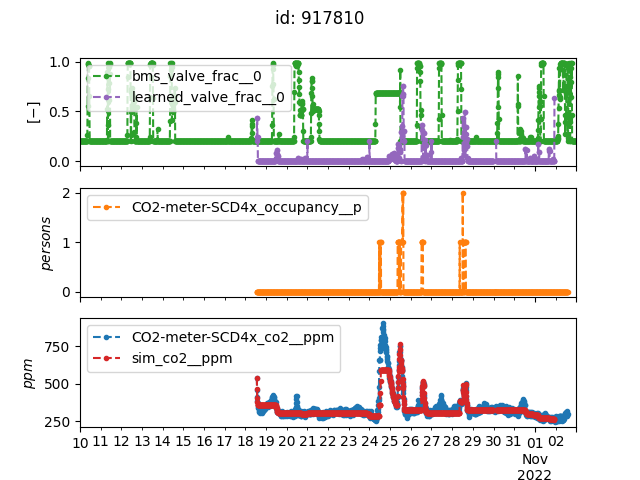

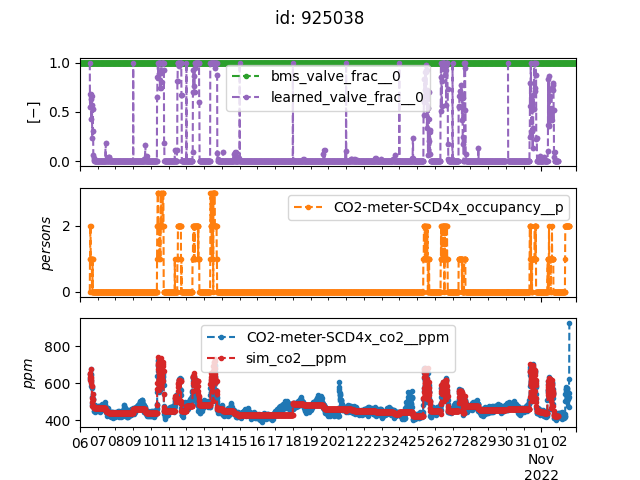

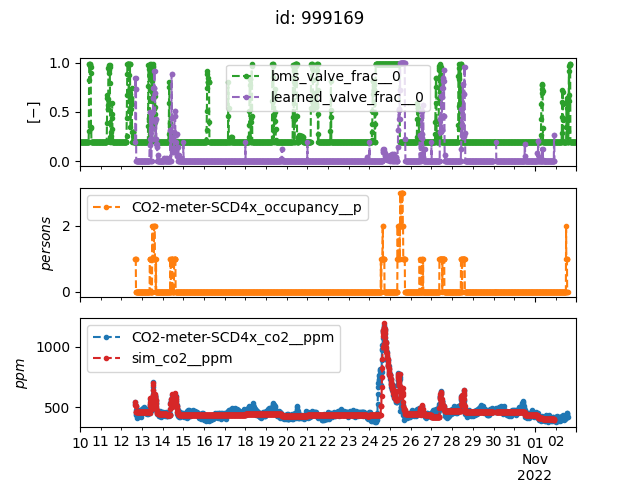

In [24]:
Plot.dataframe_preprocessed_plot(df_plot, units_to_mathtext)

In [25]:
df_plot

CO2-meter-SCD4x_co2__ppm  \
id     timestamp                                             
917810 2022-10-10 00:00:00+02:00                       NaN   
       2022-10-10 00:15:00+02:00                       NaN   
       2022-10-10 00:30:00+02:00                       NaN   
       2022-10-10 00:45:00+02:00                       NaN   
       2022-10-10 01:00:00+02:00                       NaN   
...                                                    ...   
999169 2022-11-02 22:45:00+01:00                       NaN   
       2022-11-02 23:00:00+01:00                       NaN   
       2022-11-02 23:15:00+01:00                       NaN   
       2022-11-02 23:30:00+01:00                       NaN   
       2022-11-02 23:45:00+01:00                       NaN   

                                  CO2-meter-SCD4x_occupancy__p  \
id     timestamp                                                 
917810 2022-10-10 00:00:00+02:00                          <NA>   
       2022-10-10 00:15:00+02:00                          <NA>   
       2022-10-10 00:30:00+02:00                          <NA>   
       2022-10-10 00:45:00+02:00                          <NA>   
       2022-10-10 01:00:00+02:00                          <NA>   
...                                                        ...   
999169 2022-11-02 22:45:00+01:00                          <NA>   
       2022-11-02 23:00:00+01:00                          <NA>   
       2022-11-02 23:15:00+01:00                          <NA>   
       2022-11-02 23:30:00+01:00                          <NA>   
       2022-11-02 23:45:00+01:00                          <NA>   

                                  bms_valve_frac__0  sim_co2__ppm  \
id     timestamp                                                    
917810 2022-10-10 00:00:00+02:00                0.2           NaN   
       2022-10-10 00:15:00+02:00                0.2           NaN   
       2022-10-10 00:30:00+02:00                0.2           NaN   
       2022-10-10 00:45:00+02:00                0.2           NaN   
       2022-10-10 01:00:00+02:00                0.2           NaN   
...                                             ...           ...   
999169 2022-11-02 22:45:00+01:00                0.2           NaN   
       2022-11-02 23:00:00+01:00                0.2           NaN   
       2022-11-02 23:15:00+01:00                0.2           NaN   
       2022-11-02 23:30:00+01:00                0.2           NaN   
       2022-11-02 23:45:00+01:00                0.2           NaN   

                                  learned_valve_frac__0  
id     timestamp                                         
917810 2022-10-10 00:00:00+02:00                    NaN  
       2022-10-10 00:15:00+02:00                    NaN  
       2022-10-10 00:30:00+02:00                    NaN  
       2022-10-10 00:45:00+02:00                    NaN  
       2022-10-10 01:00:00+02:00                    NaN  
...                                                 ...  
999169 2022-11-02 22:45:00+01:00                    NaN  
       2022-11-02 23:00:00+01:00                    NaN  
       2022-11-02 23:15:00+01:00                    NaN  
       2022-11-02 23:30:00+01:00                    NaN  
       2022-11-02 23:45:00+01:00                    NaN  

[7305 rows x 5 columns]

In [26]:
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7305 entries, (917810, Timestamp('2022-10-10 00:00:00+0200', tz='Europe/Amsterdam')) to (999169, Timestamp('2022-11-02 23:45:00+0100', tz='Europe/Amsterdam'))
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CO2-meter-SCD4x_co2__ppm      6061 non-null   float32
 1   CO2-meter-SCD4x_occupancy__p  6061 non-null   Int8   
 2   bms_valve_frac__0             7295 non-null   float32
 3   sim_co2__ppm                  5830 non-null   float64
 4   learned_valve_frac__0         5830 non-null   float64
dtypes: Int8(1), float32(2), float64(2)
memory usage: 550.8 KB
